# Wrangling Data From Bay Area Bike Share Published Data - Trips

### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from wranglingutils import time_marker as tm
from wranglingutils import csv_chunk_importer

In [3]:
from math import ceil

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

COLOR_BLU = '#0074C8'
COLOR_YEL = '#FACD6B'
COLOR_GRY = '#71C9BE'
COLOR_GRE = '#85B74A'

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25
TICK_FONT_SIZE = LABEL_FONT_SIZE*0.8
FIG_SIZE = (15,6)

## Import Data

<p>Trip data, records of all reported trips taken by Bike Share Users</p>

In [5]:
tip_df_columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 
                  'end_date', 'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 
                  'zip_code']

trips_df = csv_chunk_importer(file_path_slug='../00_source_data/bayareabikeshare/*trip_data.csv', 
                                 column_labels=tip_df_columns, 
                                 chunk_size=10000, 
                                 drop_dups=True)

[23:18:08.304795] Started Loading Data...
[23:18:09.720090] Finished file! ( 1 of  4)
[23:18:10.352687] Finished file! ( 2 of  4)
[23:18:11.907706] Finished file! ( 3 of  4)
[23:18:12.720120] Finished file! ( 4 of  4)
[23:18:12.720247] concatenating chunks...
[23:18:15.435722] Data Loaded Successfully!


In [6]:
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'])
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'])

In [7]:
sf_stations = pd.read_pickle('../00_clean_data/bayareabikeshare/sf_station_data_cleaned.pkl')

sf_station_ids = sf_stations.station_id.unique()

## Zip Codes
<ul>
    <li><b>us_zipcodes:</b> list of all US zipcodes, used to validate user input</li>
    <li><b>bayzips:</b> a list of all bay are zipcodes, use to determine a `local` customer</li>
</ul>

In [8]:
us_zipcodes = csv_chunk_importer(file_path_slug='../00_source_data/us_postal_codes.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)

us_zipcodes.columns = [x.replace(' ', '_').lower() for x in us_zipcodes.columns]

# left pad zip_code with zeros
us_zipcodes['zip_code'] = us_zipcodes['zip_code'].apply(lambda x: '{0:05d}'.format(x))

us_zips = [str(x) for x in us_zipcodes.zip_code.unique()]

us_zipcodes.head(3)

[23:27:59.326370] Started Loading Data...
[23:27:59.438175] Finished file! ( 1 of  1)
[23:27:59.438286] concatenating chunks...
[23:27:59.494055] Data Loaded Successfully!


,zip_code,place_name,state,state_abbreviation,county,latitude,longitude
0,00501,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
1,00544,Holtsville,New York,NY,Suffolk,40.8154,-73.0451
2,01001,Agawam,Massachusetts,MA,Hampden,42.0702,-72.6227


In [9]:
bay_area_zipcodes = csv_chunk_importer(file_path_slug='../00_source_data/bayarea_zipcodes.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)
bayzips = bay_area_zipcodes.ZIP.unique()

bayzips = [str(z) for z in bayzips]

[23:27:59.589969] Started Loading Data...
[23:27:59.612406] Finished file! ( 1 of  1)
[23:27:59.612562] concatenating chunks...
[23:27:59.622963] Data Loaded Successfully!


In [10]:
bay_zips = us_zipcodes[((us_zipcodes.state_abbreviation == 'CA') & (us_zipcodes.place_name == 'San Jose')) 
            | (us_zipcodes.zip_code.isin(bayzips))].zip_code.unique()

## check if zipcode is a valid US Zipcode

In [11]:
trips_df['zip_code'] = trips_df['zip_code'].apply(lambda x: '0' if x == 'nil' else str(x).split('-')[0].split('.')[0][:5])

In [12]:
# tag trips if they have a valid USA Zipcode
tm("tagging valid USA Zipcodes")
trips_df['us_zip']   = False
us_idx = trips_df[trips_df.zip_code.isin(us_zips)].index
trips_df.iloc[us_idx,list(trips_df.columns).index('us_zip')] = True

# replace non valid USA Zip Codes with '00000'
tm("replacing non valid zip codes with '00000'")
non_us_idx = trips_df[~trips_df.zip_code.isin(us_zips)].index
trips_df.iloc[non_us_idx,list(trips_df.columns).index('zip_code')] = '00000'

# tag trips that are in local bay area zip codes
tm("tagging local  Bay Area Zip Codes")
trips_df['is_local']   = False
local_idx = trips_df[trips_df.zip_code.isin(bayzips)].index
trips_df.iloc[local_idx,list(trips_df.columns).index('is_local')] = True

[23:28:00.944965] tagging valid USA Zipcodes
[23:28:01.320886] replacing non valid zip codes with '00000'
[23:28:01.517829] tagging local  Bay Area Zip Codes


## Append User Home City, state, and county

In [13]:
tm('merge user home state and city')
trips_df = trips_df.merge(us_zipcodes.iloc[:,[0, 1, 3, 4]], on = 'zip_code', how='left')
trips_df.rename(columns={'place_name' : 'user_home_city',
                    'state_abbreviation' : 'user_home_state',
                    'county' : 'user_home_county'}, inplace=True)

[23:28:01.754775] merge user home state and city


In [14]:
trips_df.groupby('is_local').count()['trip_id'].sort_values()

is_local
False    211969
True     771679
Name: trip_id, dtype: int64

In [15]:
trips_df.groupby('us_zip').count()['trip_id'].sort_values()

us_zip
False     42181
True     941467
Name: trip_id, dtype: int64

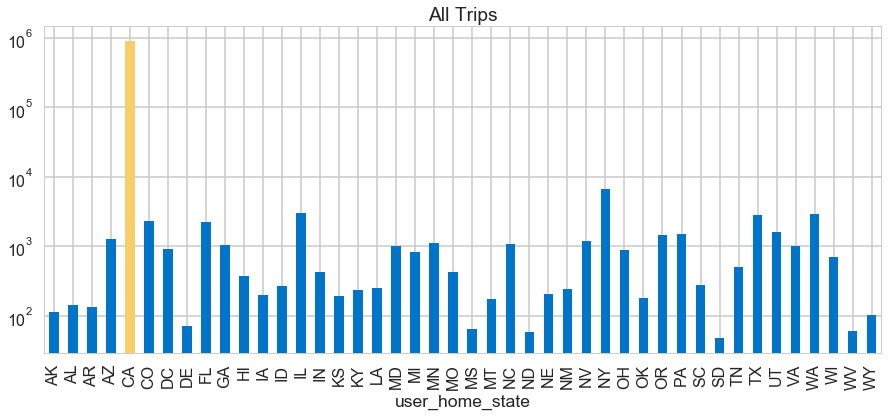

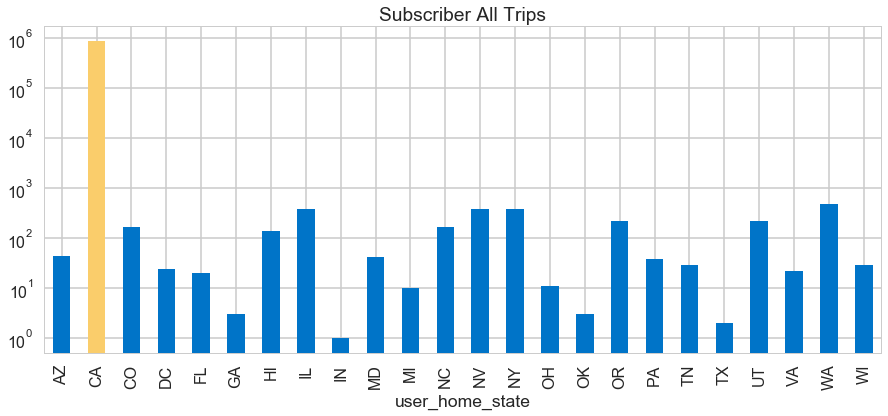

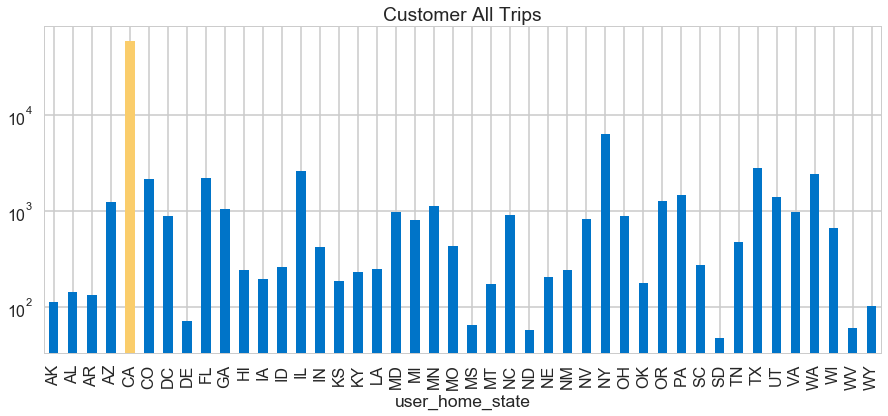

In [53]:

def plot_counts(df, logy=False, c0=COLOR_BLU, c1=COLOR_YEL, special_label='', title='plot counts', figsize=FIG_SIZE):

    color_codes = [c0 if x != special_label else c1 for x in df.index]
    ax = df.plot(figsize=figsize, kind='bar', logy=logy, color=color_codes)
    ax.set_title('{}'.format(title.title()))
    plt.show()
    plt.close()
    
df = trips_df.groupby('user_home_state').count()['trip_id'].copy()
plot_counts(df, logy=True, special_label='CA', title='All Trips')

df = trips_df[trips_df.subscriber_type == 'Subscriber'].groupby('user_home_state').count()['trip_id'].copy()
plot_counts(df, logy=True, special_label='CA', title='Subscriber All Trips')

df = trips_df[trips_df.subscriber_type != 'Subscriber'].groupby('user_home_state').count()['trip_id'].copy()
plot_counts(df, logy=True, special_label='CA', title='Customer All Trips')



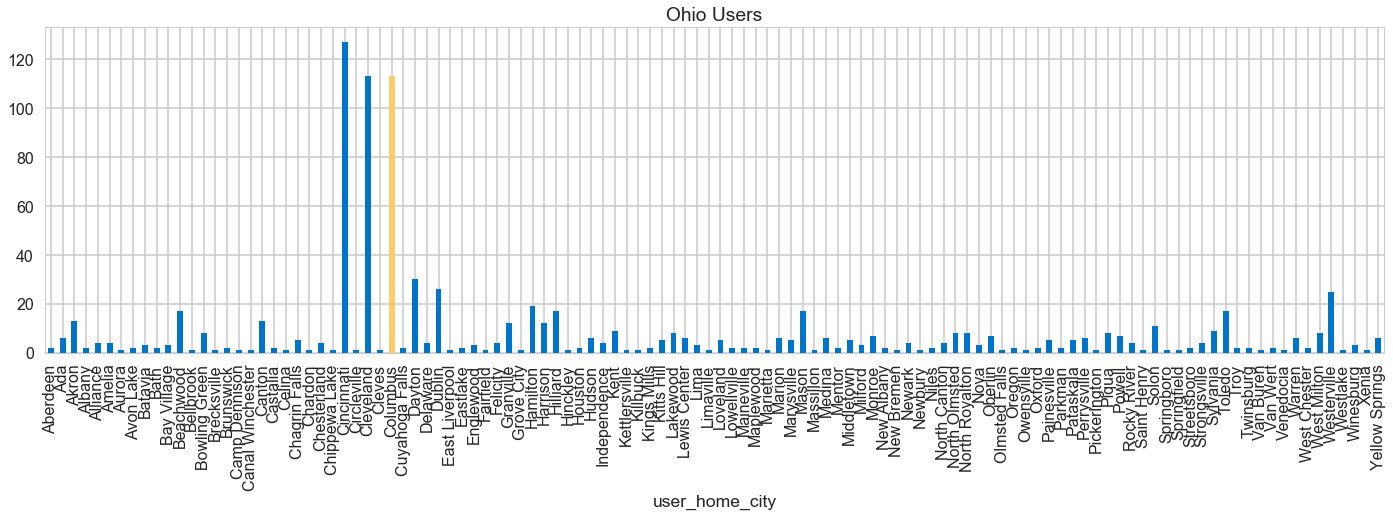

In [54]:
df = trips_df[trips_df.user_home_state == 'OH'].groupby('user_home_city').count()['trip_id']
plot_counts(df, logy=False, title='Ohio Users', special_label='Columbus', figsize=(24,6))

In [56]:
trips_df[(trips_df.user_home_state == 'OH') & (trips_df.user_home_city == 'Lewis Center')]

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,subscriber_type,zip_code,us_zip,is_local,user_home_city,user_home_state,user_home_county
518128,834519,469,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,475,Customer,43035,True,False,Lewis Center,OH,Delaware
518129,834518,478,2015-07-06 12:37:00,Golden Gate at Polk,59,2015-07-06 12:45:00,Market at 4th,76,504,Customer,43035,True,False,Lewis Center,OH,Delaware
518811,833685,244,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:23:00,Civic Center BART (7th at Market),72,426,Customer,43035,True,False,Lewis Center,OH,Delaware
518812,833684,251,2015-07-05 15:18:00,Market at 10th,67,2015-07-05 15:22:00,Civic Center BART (7th at Market),72,483,Customer,43035,True,False,Lewis Center,OH,Delaware
518831,833661,2235,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,310,Customer,43035,True,False,Lewis Center,OH,Delaware
518832,833660,2222,2015-07-05 14:38:00,Market at 10th,67,2015-07-05 15:15:00,Market at 10th,67,354,Customer,43035,True,False,Lewis Center,OH,Delaware


## Cleaning Support Functions
<p>General Cleaning functions</p>

In [ ]:
def clean_trip_frame(df):
    '''Basic Cleanup of column types and appends a 'duration_minutes' 
        column converted from given 'duration' which is in seconds'''
    # set column types
    tm('Setting data types...')
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    tm('add duration_minutes column')
    df['duration_minutes'] = df.duration.apply(lambda x: x/60.)
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # add 'billed_minutes' and 'billed_periods' columns
    # customers are billed by the minute, round up to nearest minute duration
    # a billed period is 5 minutes long
    df['billed_minutes'] = df.duration.apply(lambda x: ceil(x/60.))
    df['billed_minutes'] = df['billed_minutes'].astype('int')
    df['billed_periods'] = df.billed_minutes.apply(lambda x: int(ceil(x/5)))
    
    # Clean Zipcode
    tm('cleaning zipcodes')
    df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    df.reset_index(inplace=True, drop=True)
    
    tm('done!')
    return df

# Cleaning Data
<ul>
    <li>Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes</li>
    <li>For other data it is mostly just setting a propper data type</li>
    <li>
        <ul>Duration is convered to billable time windows as:
            <li>`billed_minutes` rounds up rental duration minutes to next full minute</li>
            <li>`billed_periods` is the number of 5 minute intervals in `billed_minutes`, rounded up to the next full period</li>
        <ul>
    </li>
</ul>

In [ ]:
# clean data frames
tm('Trip Data Cleanup Started')
trips_df = clean_trip_frame(trips_df)
tm('Cleanup Complete!')

In [ ]:
trips_df.head(3).transpose()

In [ ]:
trips_df.describe()

# Correct Relocated Stations

<p> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated </p>

In [ ]:
def date_fixes(df, old_terminal, new_terminal, change_date):
    '''Correct dates on terminal relocations'''
        
    # Fix A to B - Start Terminal
    tm('Setting {} to {} occuring before {}'.format(old_terminal, new_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal

    # Fix A to B - End Terminal
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    
    # Fix B to A - Start Terminal
    tm('Setting {} to {} occuring after  {}'.format(new_terminal, old_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_start)))
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal

    # Fix B to A - End Terminal
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    print('\tUpdating {:d} records...'.format(len(index_to_update_end)))
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    
    return df

#### On July 5, 2016 station 23 was relocated to station 88, and station 24 was relocated to station 89

In [ ]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 23, 88, change_date)
trips_df = date_fixes(trips_df, 24, 89, change_date)

#### On August 4, 2016 station 25 was relocated to station 91, and station 26 was relocated to station 90

In [ ]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trips_df = date_fixes(trips_df, 25, 91, change_date)
trips_df = date_fixes(trips_df, 26, 90, change_date)

## Prune Trips not within San Francisco
<p>We are only concerned with trips that both start and end at San Francisco Stations in this analysis, remove all others</p>

In [ ]:
tm('Subset to only include trips that are within San Francisco')
trips_df = trips_df[(trips_df.start_terminal.isin(sf_station_ids)) & (trips_df.end_terminal.isin(sf_station_ids))].copy()
tm('done')

## Prune Trips to only those less than 3 hours long
<p>The duration in minutes of each trip has a very large spread, with the longest trip (an extreme outlier) taking nearly 200 days to complete a trip!  The Bay Area Bike Share bills in Customer and Subscriber Tiers that allow for different pricing, but the global truth is that no rider can use a bike as part of the program for more than 3 hour without incurring a heafty set of fees.</p>
<p>In fact, the idealized window set out by the program is for just 30 minutes, with a minute by minute charge being tacked onto rentals for each minute the bike is not returned after that.</p>

<ul>
    <li>There are 983648 total recorded trips</li>
    <li>There are 936280 trips 30 minutes or less, this is 95.184 of all recorded trips</li>
    <li>There are 973074 trips 3 hours or less, this is 98.925 of all recorded trips</li>
</ul>

In [ ]:
count_30min_trips = trips_df[trips_df.duration_minutes < 30].shape[0]
count_3hr_trips = trips_df[trips_df.duration_minutes < 180].shape[0]

print('There are {:d} total recorded trips'.format(trips_df.shape[0]))
print('There are {:d} trips 30 minutes or less, this is {:2.3f} of all recorded trips'.format(count_30min_trips, 100.*count_30min_trips/trips_df.shape[0]))
print('There are {:d} trips 3 hours or less, this is {:2.3f} of all recorded trips'.format(count_3hr_trips, 100.*count_3hr_trips/trips_df.shape[0]))

In [ ]:
def plot_billed_min_distribution(df, max_minutes=180, file_suffix='3hr'):
    df_subset = df[df.billed_minutes <= max_minutes].copy()

    plt.subplots(figsize=FIG_SIZE)
    ax = sns.countplot(x="billed_minutes", data=df_subset, color=COLOR_BLU)

    plt.xlabel('Trip Duration (Billed Minutes)', size=LABEL_FONT_SIZE)
    plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE)
    plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE)

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    x_ticks = [x for x in range(0, max_minutes+5, 5)]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], size=TICK_FONT_SIZE)
    for x in x_ticks:
        ax.axvline(x, linestyle=':', color=COLOR_GRY, zorder=-1)


    y_ticks = [y for y in range(0, 100000, 10000)]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(['{:d}K'.format(int(y/1000)) for y in y_ticks], size=TICK_FONT_SIZE)

    plt.grid(False)
    plt.tight_layout()
    plt.savefig('../charts/trip_duration_distribution_{}.png'.format(file_suffix))
    plt.show()
    plt.close()

In [ ]:
plot_billed_min_distribution(trips_df, max_minutes=180, file_suffix='3hr')

In [ ]:
plot_billed_min_distribution(trips_df, max_minutes=30, file_suffix='30min')

In [ ]:
# prune data to exclude trips longer than 3 hours
tm('Removing trips longer than 3 hours')

cutoff_minutes = 180

trips_df = trips_df[trips_df.billed_minutes < cutoff_minutes].copy()
trips_df.reset_index(inplace=True, drop=True)

print(trips_df.shape)
tm('done!')

In [ ]:
trips_df.head(3).transpose()

## Clean Up Column Labels

In [ ]:
trips_df.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 
                    'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 
                    'bike_id', 'user_type', 'user_zip', 'duration_minutes', 
                    'billed_minutes', 'billed_periods']
trips_df.head()

# Calculate Additional Charges

<ul>
    <li><b>Subscribers:</b> get first 45 mintues free, then \$3.00 per additional 15 minute rental window</li>
    <li><b>Customers:</b> get first 30 minutes free, then \$3.00 per additinal 15 minute rental window</li>
</ul>

In [ ]:
def trip_additional_charges(user_type, billed_minutes):
    
    if user_type.title() == 'Subscriber':
        return ceil((billed_minutes - 45) / 15)*3
        
    elif user_type.title() == 'Customer':
        return ceil((billed_minutes - 30) / 15)*3    
    
    else:
        return 0.0

In [ ]:
trips_df['additional_charges'] = trips_df.apply(lambda row: trip_additional_charges(row['user_type'], row['billed_minutes']), axis=1)

In [ ]:
trips_df.head(3).transpose()

# Write Data to File

In [ ]:
trips_df.to_pickle('../00_clean_data/bayareabikeshare/trips_cleaned.pkl')

In [ ]:
trips_df.info()